# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import math

from pathlib import Path
from importlib import reload

from sklearn.linear_model import LinearRegression

In [2]:
import files_io as files_io
import cleaning as cleaning
import exploration as exploration

In [3]:
cm = 1/2.54

# PATHS

In [4]:
path_data = '/home/lemasle/ASTRO/electricity_consumption/datasets/UC_Irvine_ML_repository/'
path_figs = Path('./figs')

# IMPORT & CLEAN DATA

In [5]:
files_io.extract_zip(path_data, 'individual+household+electric+power+consumption.zip')
data = files_io.import_data_UCI(path_data, 'household_power_consumption.txt')
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [6]:
# 1.date: Date in format dd/mm/yyyy
# 2.time: time in format hh:mm:ss
# 3.global_active_power: household global minute-averaged active power (in kilowatt)
# 4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
# 5.voltage: minute-averaged voltage (in volt)
# 6.global_intensity: household global minute-averaged current intensity (in ampere)
# 7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
# 8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
# 9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [7]:
count, percent = cleaning.check_nans(data)

NULL VALUES PER COLUMN:
date                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
% OF NULL VALUES PER COLUMN:
date                     0.0
Global_active_power      1.3
Global_reactive_power    1.3
Voltage                  1.3
Global_intensity         1.3
Sub_metering_1           1.3
Sub_metering_2           1.3
Sub_metering_3           1.3
dtype: float64


In [8]:
list_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# interpolation to replace NaNs
for i in range(len(list_col)):
    data[str(list_col[i])] = data[str(list_col[i])].interpolate()

count, percent = cleaning.check_nans(data)

NULL VALUES PER COLUMN:
date                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
% OF NULL VALUES PER COLUMN:
date                     0.0
Global_active_power      0.0
Global_reactive_power    0.0
Voltage                  0.0
Global_intensity         0.0
Sub_metering_1           0.0
Sub_metering_2           0.0
Sub_metering_3           0.0
dtype: float64


# FEATURE CREATION: Sub_metering_rest

In [9]:
# Electricity consumption not taken into account by the sub-meters 1-3

In [10]:
exploration.create_rest_feature(data)
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [11]:
# update list of cols:
list_col = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_rest']

In [12]:
# CREATE HOURLY/DAILY/MONTHLY dataframes

In [13]:
data_h = cleaning.get_data_hourly_averaged(data)
data_hcat = cleaning.timestamps_as_categories(data_h)
data_hcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,week,dayofmonth,dayofyear,year,month
0,2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593,5,Saturday,50,16,350,2006,12
1,2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333,5,Saturday,50,16,350,2006,12
2,2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889,5,Saturday,50,16,350,2006,12
3,2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778,5,Saturday,50,16,350,2006,12
4,2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,5,Saturday,50,16,350,2006,12


In [14]:
data_d = cleaning.get_data_daily_averaged(data)
data_dcat = cleaning.timestamps_as_categories(data_d)
data_dcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,week,dayofmonth,dayofyear,year,month
0,2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,37.073064,5,Saturday,50,16,350,2006,12
1,2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,25.657407,6,Sunday,50,17,351,2006,12
2,2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,13.214190,0,Monday,51,18,352,2006,12
3,2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375,1,Tuesday,51,19,353,2006,12
4,2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,14.156111,2,Wednesday,51,20,354,2006,12


In [15]:
data_m = cleaning.get_data_monthly_averaged(data)
data_mcat = cleaning.timestamps_as_categories(data_m)
data_mcat.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,week,dayofmonth,dayofyear,year,month
0,2006-12-31,1.901564,0.131398,241.440787,8.031087,1.251819,2.216721,7.409802,20.814395,6,Sunday,52,31,365,2006,12
1,2007-01-31,1.546086,0.132682,240.904805,6.547142,1.264180,1.775862,7.383748,15.344316,2,Wednesday,5,31,31,2007,1
2,2007-02-28,1.401211,0.113636,240.519176,5.915104,1.180159,1.603175,6.704067,13.866116,2,Wednesday,9,28,59,2007,2
3,2007-03-31,1.318609,0.114749,240.513516,5.572905,1.361313,2.346819,6.504503,11.764188,5,Saturday,13,31,90,2007,3
4,2007-04-30,0.845583,0.120865,239.055733,3.633866,0.974028,0.889282,4.386644,7.843099,0,Monday,18,30,120,2007,4


# DATA EXPLORATION

## Trends

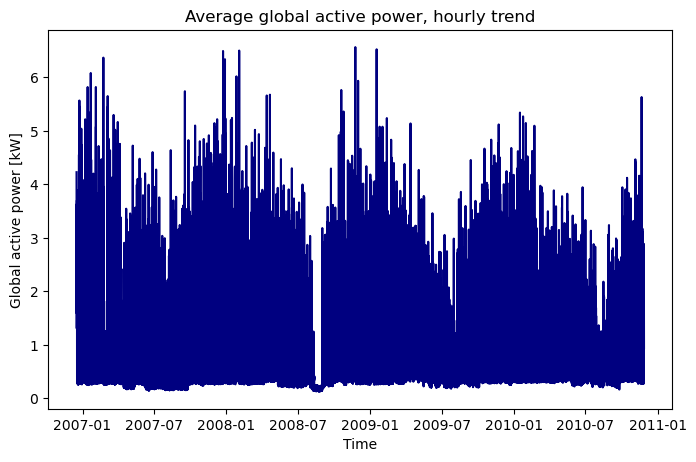

In [16]:
exploration.plot_trend(data_h, 'Global_active_power', 'Time', 'Global active power [kW]', \
                       'Average global active power, hourly trend', path_figs, 'UCI_hourly_averaged_trend', cm)

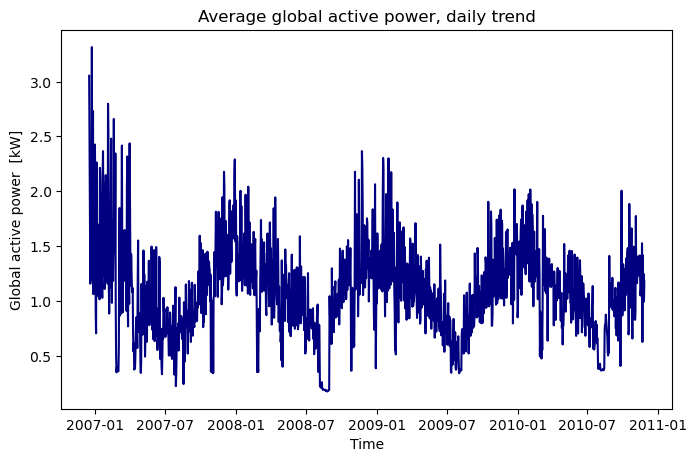

In [17]:
exploration.plot_trend(data_d, 'Global_active_power', 'Time', 'Global active power  [kW]', \
           'Average global active power, daily trend', path_figs, 'UCI_daily_averaged_trend', cm)

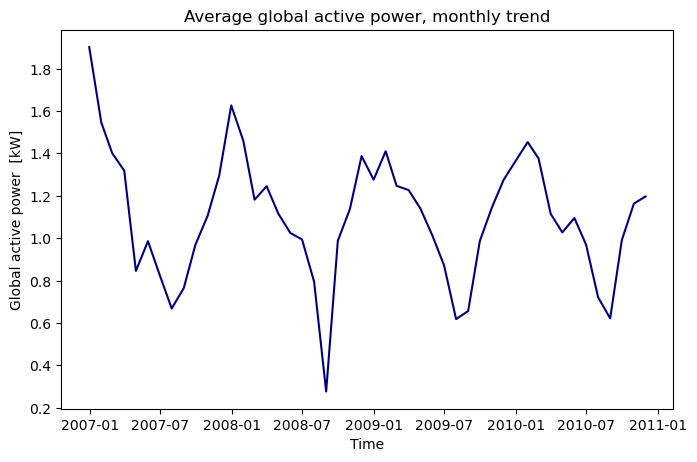

In [18]:
exploration.plot_trend(data_m, 'Global_active_power', 'Time', 'Global active power  [kW]', \
           'Average global active power, monthly trend', path_figs, 'UCI_monthly_averaged_trend', cm)

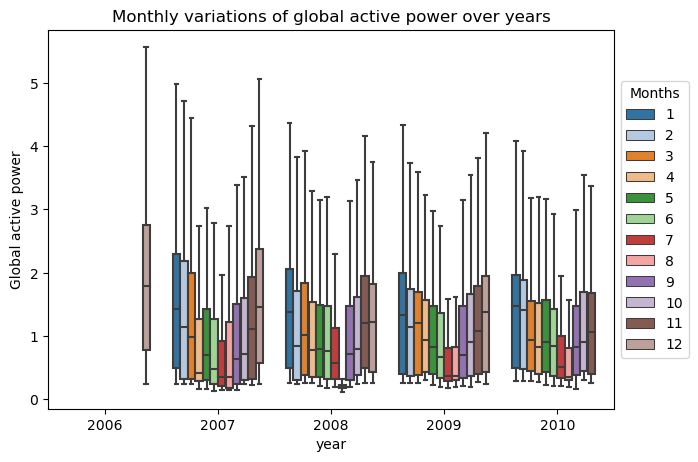

In [19]:
exploration.multiyear_boxplot(data_hcat, 'Global_active_power', 'month', r'year', r'Global active power', \
            r'Monthly variations of global active power over years', 'Months', path_figs, 'UCI_global_active_power_per_month_over_years.pdf', cm)

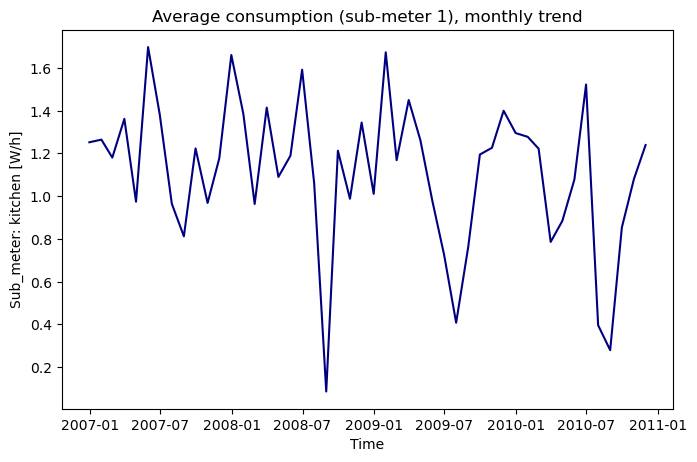

In [20]:
exploration.plot_trend(data_m, 'Sub_metering_1', 'Time', 'Sub_meter: kitchen [W/h]', \
           'Average consumption (sub-meter 1), monthly trend', path_figs, 'UCI_SM1_monthly_averaged_trend', cm)

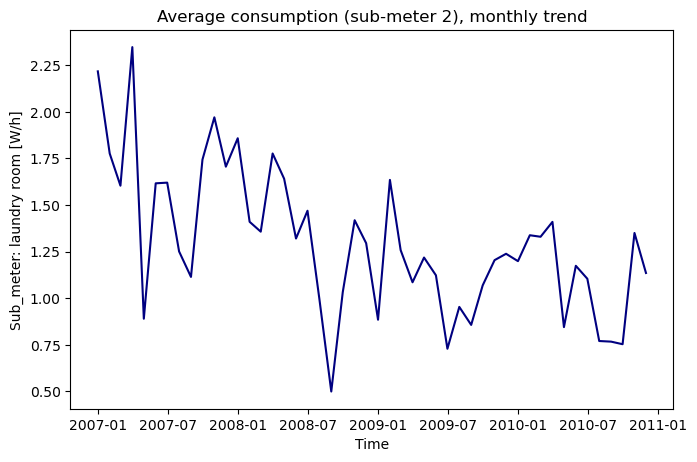

In [21]:
exploration.plot_trend(data_m, 'Sub_metering_2', 'Time', 'Sub_meter: laundry room [W/h]', \
           'Average consumption (sub-meter 2), monthly trend', path_figs, 'UCI_SM2_monthly_averaged_trend', cm)

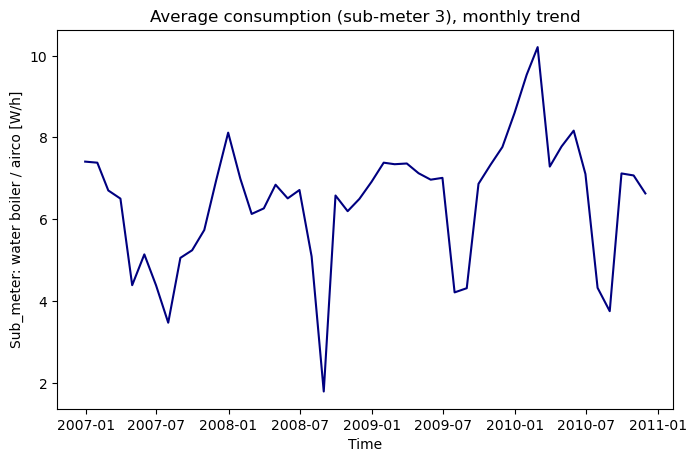

In [22]:
exploration.plot_trend(data_m, 'Sub_metering_3', 'Time', 'Sub_meter: water boiler / airco [W/h]', \
           'Average consumption (sub-meter 3), monthly trend', path_figs, 'UCI_SM3_monthly_averaged_trend', cm)

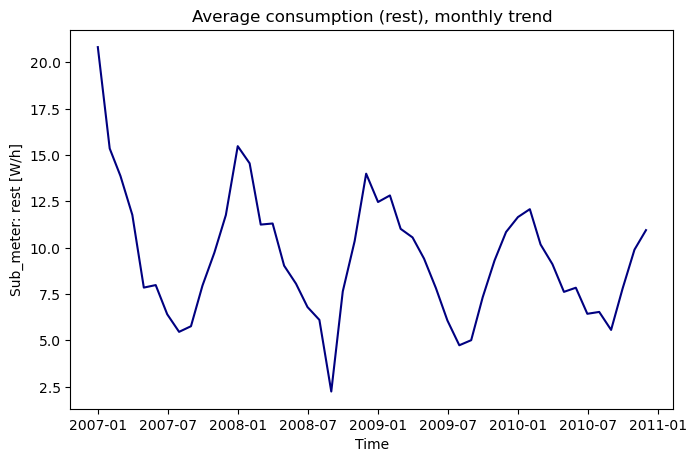

In [23]:
exploration.plot_trend(data_m, 'Sub_metering_rest', 'Time', 'Sub_meter: rest [W/h]', \
           'Average consumption (rest), monthly trend', path_figs, 'UCI_SM3_monthly_averaged_trend', cm)

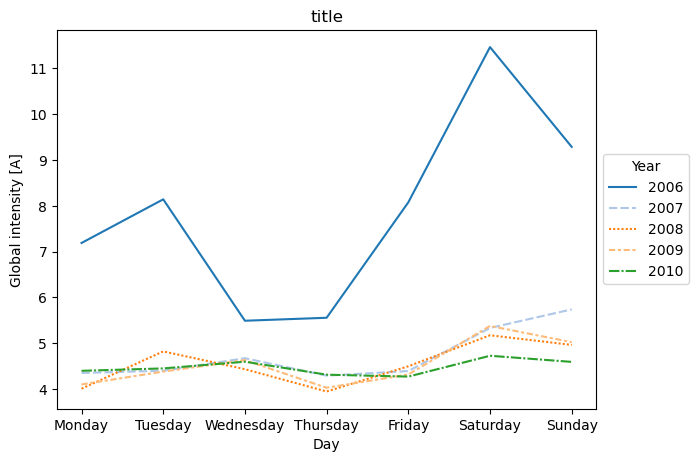

In [24]:
exploration.average_per_dayofweek_plot(data_hcat, 'year', 'Global_intensity', r'Day', r'Global intensity [A]', r'title', r'Year', \
                                       path_figs, 'UCI_average_of_the_global_intensity_per_dayofweek.pdf', cm)

In [25]:
# 2006 data only contains the last two weeks od December.

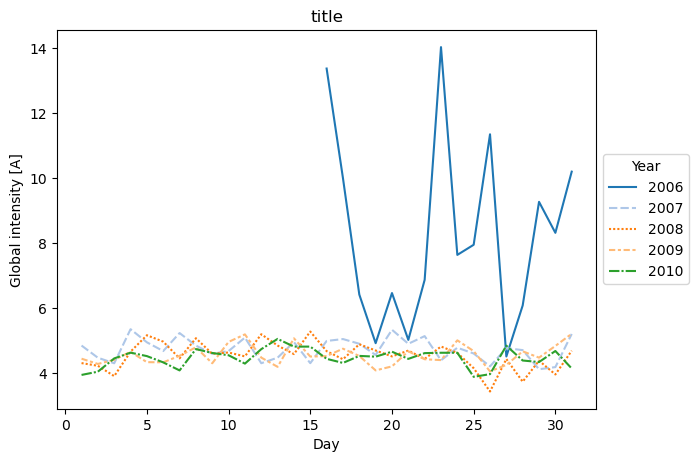

In [26]:
exploration.average_per_dayofmonth_plot(data_hcat, 'year', 'Global_intensity', r'Day', r'Global intensity [A]', r'title', r'Year', \
                              path_figs, 'UCI_average_of_the_global_intensity_per_dayofmonth.pdf', cm)

## DATA DISTRIBUTION PROFILES

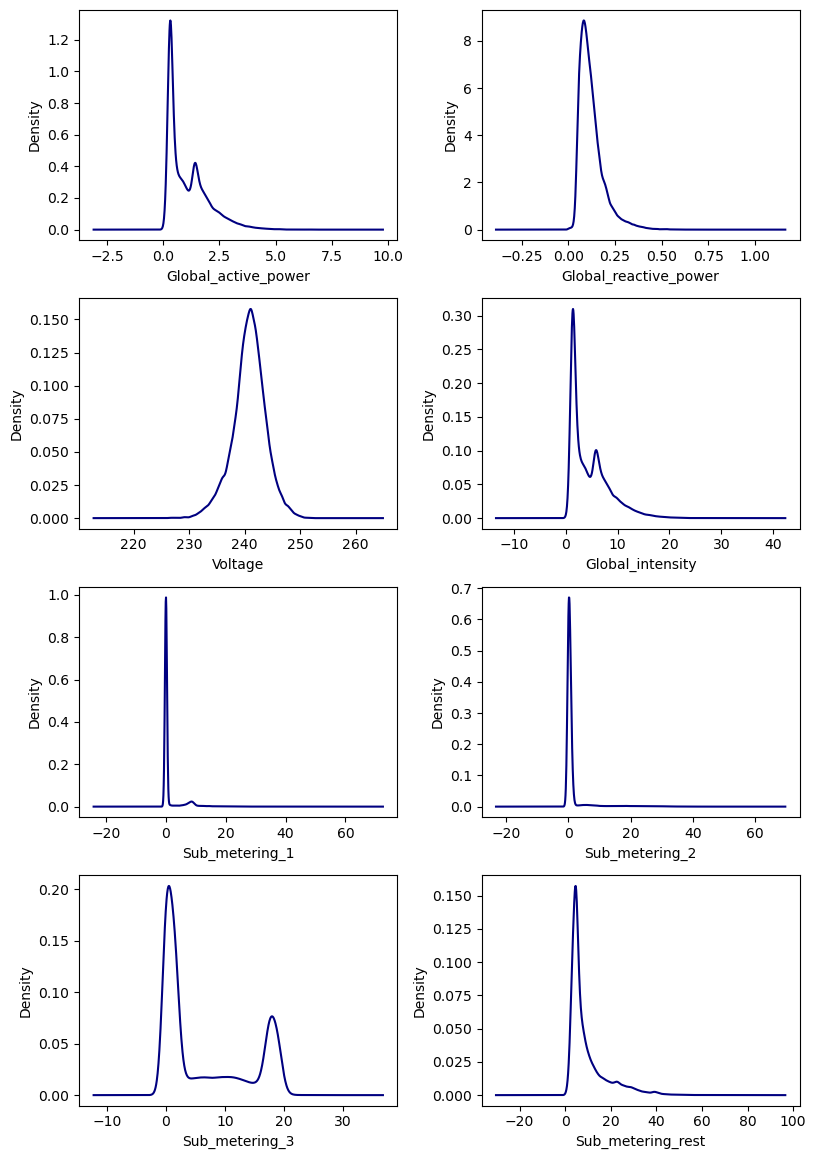

In [27]:
exploration.multiplot_density_distributions(data_h, list_col, path_figs, 'Density_distributions_hourly_data.pdf', cm)

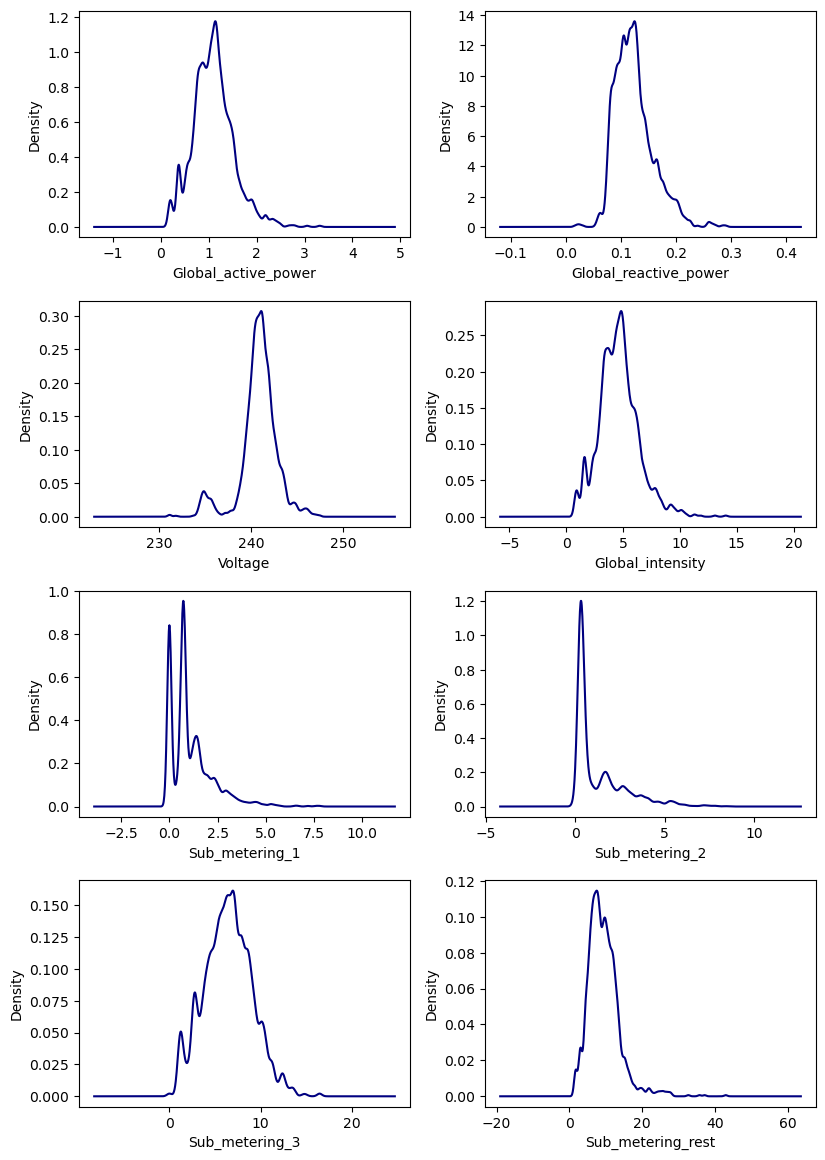

In [28]:
exploration.multiplot_density_distributions(data_d, list_col, path_figs, 'Density_distributions_daily_data.pdf', cm)

### In most cases: not Gaussian --> avoid feature selection methods that require Gaussian profile

# SPLIT TRAIN/TEST DATA

In [29]:
# hourly averaged data
train_h = data_hcat.loc[data_hcat.year<2010]
test_h = data_hcat.loc[data_hcat.year==2010]
print(len(train_h), len(test_h))

# daily averaged data
train_d = data_dcat.loc[data_dcat.year<2010]
test_d = data_dcat.loc[data_dcat.year==2010]
print(len(train_d), len(test_d))

26671 7918
1112 330


In [30]:
# Say we want to predict 'Global active power' based on the rest
# Probably does not make much sense from an electrical point of view, just for the sake of the exercise...

In [31]:
X_trainh = train_h.set_index('date')
X_trainh

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,week,dayofmonth,dayofyear,year,month
date,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593,5,Saturday,50,16,350,2006,12
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333,5,Saturday,50,16,350,2006,12
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889,5,Saturday,50,16,350,2006,12
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778,5,Saturday,50,16,350,2006,12
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,5,Saturday,50,16,350,2006,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,3.062867,0.186967,237.248333,12.846667,0.0,0.116667,17.900000,33.031111,3,Thursday,53,31,365,2009,12
2009-12-31 20:00:00,2.842500,0.158767,237.794500,11.900000,0.0,0.000000,17.966667,29.408333,3,Thursday,53,31,365,2009,12
2009-12-31 21:00:00,2.875367,0.215600,236.641500,12.100000,0.0,0.350000,18.716667,28.856111,3,Thursday,53,31,365,2009,12


In [32]:
y_trainh = train_h.set_index('date').Global_active_power
y_trainh.head()

date
2006-12-16 17:00:00    4.222889
2006-12-16 18:00:00    3.632200
2006-12-16 19:00:00    3.400233
2006-12-16 20:00:00    3.268567
2006-12-16 21:00:00    3.056467
Name: Global_active_power, dtype: float64

# RESCALE DATA

# TBD TBD TBD TBD TBD TBD

In [33]:
list_col_scld = [s + '_scld' for s in list_col]

# FEATURE SELECTION

In [34]:
#lags_in_d = np.append(np.arange(31), [181,182,364])
lags_in_d = np.arange(31)
lags_in_h = np.arange(48)
lags_in_d

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

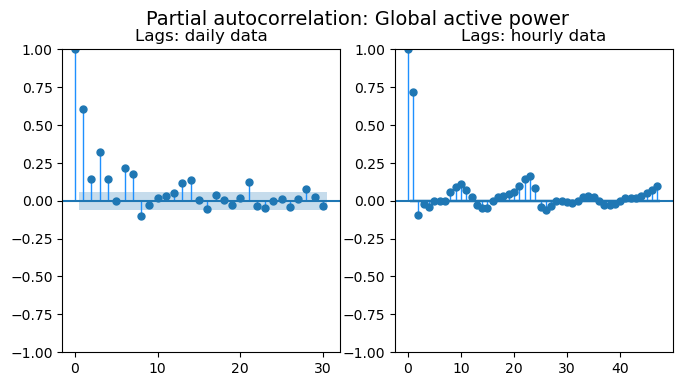

In [35]:
fig, ax = plt.subplots(1,2, figsize=(20*cm, 10*cm))
fig.suptitle("Partial autocorrelation: Global active power", fontsize=14)
p1 = sm.graphics.tsa.plot_pacf(train_d.Global_active_power, lags=lags_in_d, method='ywm', ax=ax[0], \
                                      title = 'Lags: daily data', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

p2 = sm.graphics.tsa.plot_pacf(train_h.Global_active_power, lags=lags_in_h, method='ywm', ax=ax[1], \
                                      title = 'Lags: hourly data', \
                                      vlines_kwargs={'color': 'dodgerblue', 'lw':1})

In [36]:
pacf_d = exploration.get_lags_sorted_by_pacf(train_d.Global_active_power, nlags=366, alpha=0.05, threshold=0.1)
print(pacf_d)

pacf_h = exploration.get_lags_sorted_by_pacf(train_h.Global_active_power, nlags=48, alpha=0.05, threshold=0.07)
print(pacf_h)

       value  lag
1   0.604957    1
2   0.323216    3
3   0.220149    6
4   0.178741    7
5   0.145675    2
6   0.145373    4
7   0.136328   14
8   0.129028   21
9   0.120287  364
10  0.119381   13
11  0.107845   42
12  0.104275    8
       value  lag
1   0.719769    1
2   0.160294   23
3   0.141516   22
4   0.110445   10
5   0.099297   21
6   0.099107   47
7   0.092408    2
8   0.088090    9
9   0.084536   24
10  0.072247   46
11  0.071968   11


# CREATE LAG FEATURES

In [37]:
lag_list_d = pacf_d.lag.to_list()
print(lag_list_d)
lag_list_h = pacf_h.lag.to_list()
print(lag_list_h)

[1, 3, 6, 7, 2, 4, 14, 21, 364, 13, 42, 8]
[1, 23, 22, 10, 21, 47, 2, 9, 24, 46, 11]


In [38]:
exploration.create_lag_features(X_trainh, 'Global_active_power', lag_list_h)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_rest,day,dayname,...,lag_23,lag_22,lag_10,lag_21,lag_47,lag_2,lag_9,lag_24,lag_46,lag_11
date,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593,5,Saturday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333,5,Saturday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889,5,Saturday,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.222889,0.000000,0.000000,0.000000,0.000000
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778,5,Saturday,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.632200,0.000000,0.000000,0.000000,0.000000
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778,5,Saturday,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.400233,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 19:00:00,3.062867,0.186967,237.248333,12.846667,0.0,0.116667,17.900000,33.031111,3,Thursday,...,4.173800,2.965167,1.877533,0.910267,0.715000,1.812300,2.067033,3.788500,0.952567,1.630633
2009-12-31 20:00:00,2.842500,0.158767,237.794500,11.900000,0.0,0.000000,17.966667,29.408333,3,Thursday,...,2.965167,0.910267,2.067033,0.392533,0.952567,2.967867,1.612700,4.173800,1.347467,1.877533
2009-12-31 21:00:00,2.875367,0.215600,236.641500,12.100000,0.0,0.350000,18.716667,28.856111,3,Thursday,...,0.910267,0.392533,1.612700,0.337700,1.347467,3.062867,1.558300,2.965167,1.153667,2.067033


In [39]:
# DROP COLUMNS
X_trainh = X_trainh.drop(columns=['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
                           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_rest', \
                           'day', 'dayname', 'week', 'dayofmonth', 'month', 'dayofyear', 'year'])

In [40]:
print(X_trainh.columns)

Index(['lag_1', 'lag_23', 'lag_22', 'lag_10', 'lag_21', 'lag_47', 'lag_2',
       'lag_9', 'lag_24', 'lag_46', 'lag_11'],
      dtype='object')


# FIT: LINEAR REGRESSION MODEL

In [41]:
model_trainh = LinearRegression().fit(X_trainh,y_trainh)
yfit_trainh = pd.Series(
                        model_trainh.predict(X_trainh),
                        index = X_trainh.index,
                        )

In [42]:
reload(exploration)

<module 'exploration' from '/home/lemasle/ASTRO/electricity_consumption/exploration.py'>

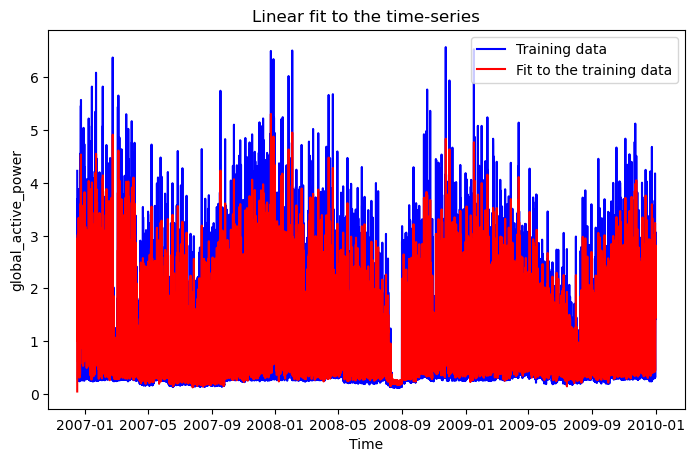

In [43]:
exploration.plot_ts_fit(y_trainh, yfit_trainh, 'Time', 'global_active_power', 'Linear fit to the time-series', 
            path_figs, 'forecasting_simple_fit.pdf', cm)

# TEST: LINEAR REGRESSION MODEL

In [44]:
X_testh = test_h.set_index('date')

In [45]:
y_testh = test_h.set_index('date').Global_active_power
y_testh.head()

date
2010-01-01 00:00:00    1.085867
2010-01-01 01:00:00    0.651233
2010-01-01 02:00:00    0.634600
2010-01-01 03:00:00    0.653000
2010-01-01 04:00:00    0.646067
Name: Global_active_power, dtype: float64

In [46]:
exploration.create_lag_features(X_testh, 'Global_active_power', lag_list_h)
# DROP COLUMNS
X_testh = X_testh.drop(columns=['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', \
                           'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Sub_metering_rest', \
                           'day', 'dayname', 'week', 'dayofmonth', 'month', 'dayofyear', 'year'])
X_testh

,lag_1,lag_23,lag_22,lag_10,lag_21,lag_47,lag_2,lag_9,lag_24,lag_46,lag_11
date,,,,,,,,,,,
2010-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-01 01:00:00,1.085867,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-01 02:00:00,0.651233,0.000000,0.000000,0.000000,0.000000,0.000000,1.085867,0.000000,0.000000,0.000000,0.000000
2010-01-01 03:00:00,0.634600,0.000000,0.000000,0.000000,0.000000,0.000000,0.651233,0.000000,0.000000,0.000000,0.000000
2010-01-01 04:00:00,0.653000,0.000000,0.000000,0.000000,0.000000,0.000000,0.634600,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.067933,2.211600,2.330467,2.883933,1.647833,2.061133,0.876433,1.999300,1.480100,1.498233,1.008767
2010-11-26 18:00:00,1.725900,2.330467,1.647833,1.999300,1.342933,1.498233,1.067933,1.849967,2.211600,2.312867,2.883933
2010-11-26 19:00:00,1.573467,1.647833,1.342933,1.849967,1.247567,2.312867,1.725900,1.352767,2.330467,1.568367,1.999300


In [47]:
model_trainh = LinearRegression().fit(X_trainh,y_trainh)
ypred_testh = pd.Series(
                        model_trainh.predict(X_testh),
                        index = X_testh.index,
                        )

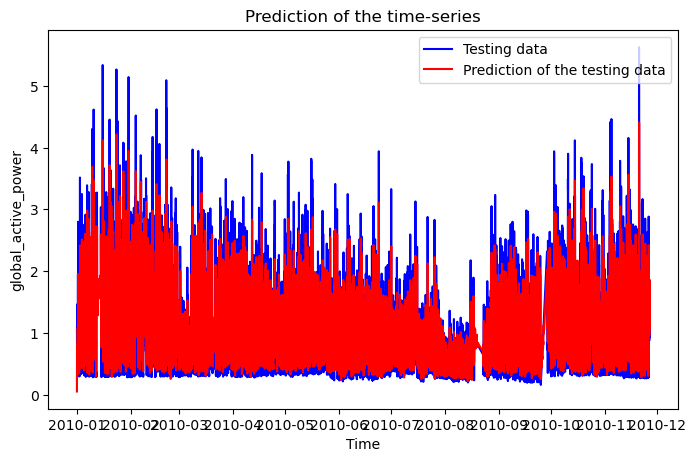

In [48]:
exploration.plot_ts_test(y_testh, ypred_testh, 'Time', 'global_active_power', 'Prediction of the time-series', 
            path_figs, 'forecasting_simple_fit.pdf', cm)

# FIT: RANDOM FOREST MODEL

In [49]:
from sklearn.ensemble import RandomForestRegressor

# fit random forest model
model_rf = RandomForestRegressor(n_estimators=100, random_state=1121218)
model_rf.fit(X_trainh, y_trainh)

y_fit_rf = pd.Series(
    model_rf.predict(X_trainh),
    index = X_trainh.index,
)

[0.56577258 0.06853065 0.03511828 0.03418872 0.03504921 0.05141233
 0.04989965 0.03661685 0.04395787 0.03608161 0.04337226]


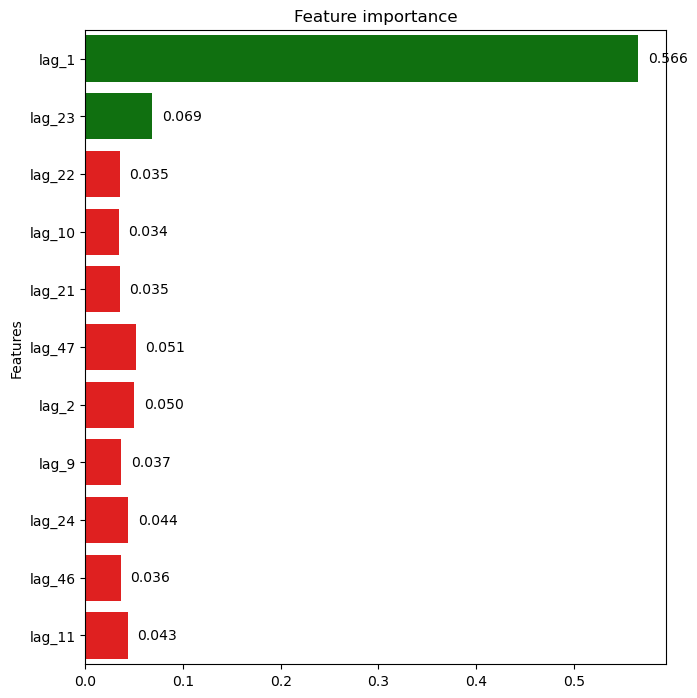

In [50]:
# print importance scores
print(model_rf.feature_importances_)
# plot importance scores
exploration.plot_feature_importance(model_rf, X_trainh, 0.06, path_figs, 'feature_importance.pdf', cm)

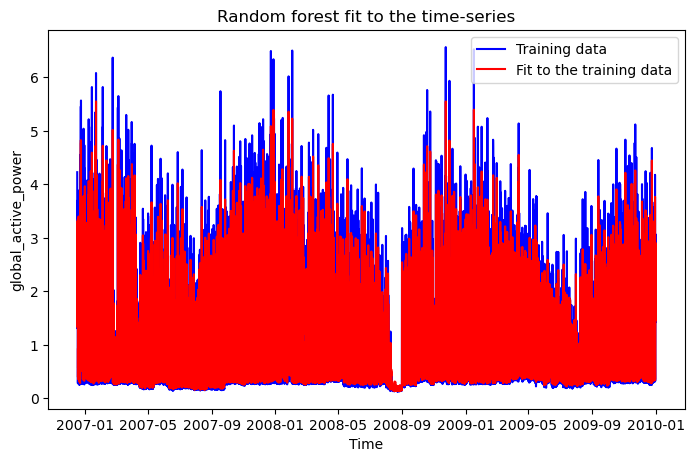

In [51]:
exploration.plot_ts_fit(y_trainh, y_fit_rf, 'Time', 'global_active_power', 'Random forest fit to the time-series', 
            path_figs, 'forecasting_random_forest_fit.pdf', cm)

# TEST: RANDOM FOREST MODEL

In [52]:
ypred_rf = pd.Series(
                    model_rf.predict(X_testh),
                    index = X_testh.index,
                    )

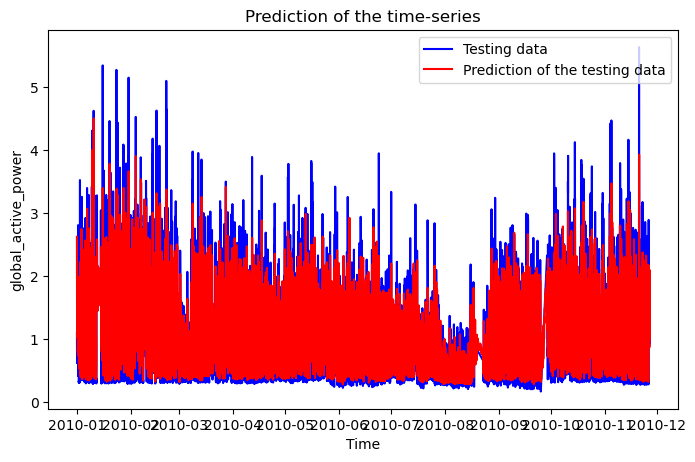

In [53]:
exploration.plot_ts_test(y_testh, ypred_rf, 'Time', 'global_active_power', 'Prediction of the time-series', 
            path_figs, 'forecasting_simple_fit.pdf', cm)

Type of target: continuous
Optimal number of features: 8


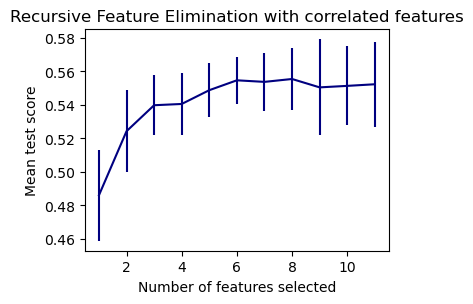

In [54]:
reload(exploration)
rfecv, optimal_n_feat = exploration.feature_selection_withcv(X_trainh, y_trainh, path_figs, cm)

selected features: ['lag_1' 'lag_23' 'lag_22' 'lag_47' 'lag_2' 'lag_9' 'lag_24' 'lag_11']


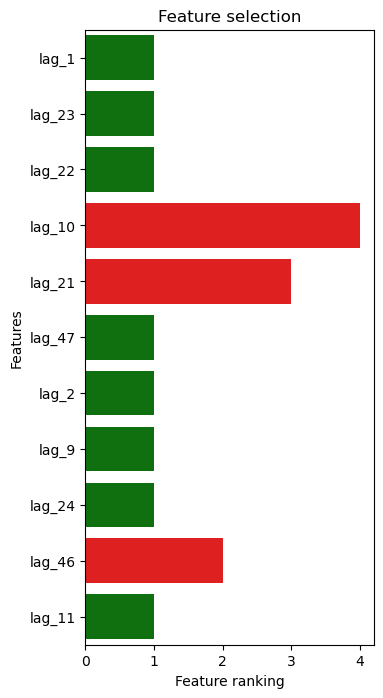

In [56]:
exploration.feature_selection_nfeat(X_trainh, y_trainh, optimal_n_feat, path_figs, 'rfe_feature_selection.pdf', cm)  

# EVALUATION METRICS

# TBD TBD TBD TBD TBD TBD